In [ ]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import numpy as np
import plotly.express as px
import copy
import re
import os
from datetime import datetime
import seaborn as sns
import glob
import datetime
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Loading

#### Reference Documentation for tennis_clean here: https://rdrr.io/github/kattaoa/oktennis/

In [ ]:
tennis_clean =  "/content/drive/MyDrive/DS340W/Tennis Clean.csv"
ATP = "/content/drive/MyDrive/DS340W/ATP.csv"

tennis_clean_table = pd.read_csv(tennis_clean, sep = ",",encoding = "latin-1")
ATP_stats = pd.read_csv(ATP)

In [ ]:
tennis_clean_table

,Unnamed: 0,pbp_id,match_num,set_num,game_num,pbp,server,returner,winner,player1_serve,...,diff_set,lagging_hand,leading_hand,diff_hand,diff_rank,diff_serve_won,diff_ret_won,lagging_age,leading_age,diff_age
0,1,10434613,1,set1,4,SRRSSS,4,2,server,0,...,0,1,1,0,44,-0.07,-0.07,22,24,-2
1,2,10434613,1,set1,4,SRRSSS,4,2,server,0,...,0,1,1,0,44,0.03,0.03,22,24,-2
2,3,10434613,1,set2,8,SDRRAR,2,4,returner,1,...,-1,1,1,0,44,-0.07,-0.07,22,24,-2
3,4,10434613,1,set2,8,SDRRAR,2,4,returner,1,...,-1,1,1,0,44,0.03,0.03,22,24,-2
4,5,10434612,5,set1,8,RSRRR,1,4,returner,0,...,0,1,1,0,14,0.07,0.07,28,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17675,17676,8616879,13038,set4,5,SSSS,4,0,server,1,...,-1,1,1,0,298,-0.06,-0.06,26,26,0
17676,17677,8616879,13038,set4,6,RRRR,0,4,returner,0,...,-1,1,1,0,298,-0.06,-0.06,26,26,0
17677,17678,8625520,13048,set1,6,SSSRS,4,1,server,0,...,0,1,1,0,182,-0.10,-0.10,22,31,-9
17678,17679,8625520,13048,set1,8,SSSS,4,0,server,0,...,0,1,1,0,182,-0.10,-0.10,22,31,-9


In [ ]:
tennis_clean_table.shape

(17680, 108)

In [ ]:
ATP_stats

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,...,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed
0,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,R,NaN,110023,AUS,Richard Coulthard,NaN,NaN,NaN
1,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.520876,NaN,R,NaN,109803,AUS,John Brown,NaN,NaN,NaN
2,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.216290,NaN,R,NaN,100257,AUS,Ross Case,NaN,NaN,NaN
3,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.264203,NaN,R,NaN,100105,AUS,Allan Stone,NaN,NaN,5.0
4,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.861739,NaN,R,NaN,109966,AUS,Warren Jacques,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169685,3,NaN,54.0,43.0,16.0,15.0,13.0,5.0,3.0,1.0,...,22.740000,NaN,R,NaN,106426,CHI,Christian Garin,92.0,620.0,NaN
169686,3,NaN,23.0,12.0,5.0,7.0,0.0,8.0,3.0,2.0,...,20.180000,NaN,R,NaN,134770,NOR,Casper Ruud,108.0,527.0,NaN
169687,3,NaN,56.0,39.0,13.0,12.0,5.0,5.0,3.0,1.0,...,28.780000,NaN,L,185.0,105550,ARG,Guido Pella,48.0,975.0,3.0
169688,3,NaN,34.0,24.0,11.0,10.0,5.0,6.0,3.0,0.0,...,22.740000,NaN,R,NaN,106426,CHI,Christian Garin,92.0,620.0,NaN


In [ ]:
match = "/content/drive/MyDrive/DS340W/match_data.csv"
match_data = pd.read_csv(match)
match_data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,0,2022-8888,Atp Cup,Hard,16,A,20220103,300,200000,NaN,...,32.0,7.0,10.0,3.0,5.0,11.0,3308.0,19.0,2260.0,2022
1,1,2022-8888,Atp Cup,Hard,16,A,20220103,299,133430,NaN,...,21.0,8.0,9.0,3.0,6.0,14.0,2475.0,20.0,2230.0,2022
2,2,2022-8888,Atp Cup,Hard,16,A,20220103,298,105138,NaN,...,62.0,20.0,16.0,6.0,7.0,19.0,2260.0,9.0,3706.0,2022
3,3,2022-8888,Atp Cup,Hard,16,A,20220103,297,105807,NaN,...,17.0,1.0,7.0,4.0,8.0,20.0,2230.0,860.0,18.0,2022
4,4,2022-8888,Atp Cup,Hard,16,A,20220103,296,106421,NaN,...,22.0,4.0,8.0,3.0,7.0,2.0,8640.0,11.0,3308.0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2728,2021-9210,Laver Cup,Hard,8,A,20210924,102,126610,NaN,...,NaN,NaN,NaN,NaN,NaN,7.0,5173.0,11.0,3368.0,2021
68207,2729,2021-9210,Laver Cup,Hard,8,A,20210924,103,106421,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,10575.0,12.0,3310.0,2021
68208,2730,2021-9210,Laver Cup,Hard,8,A,20210924,104,126094,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,6130.0,15.0,2800.0,2021
68209,2731,2021-9210,Laver Cup,Hard,8,A,20210924,105,100644,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,7760.0,22.0,2171.0,2021


In [ ]:
match_data.describe()

,Unnamed: 0,draw_size,tourney_date,match_num,winner_id,winner_ht,winner_age,loser_id,loser_ht,loser_age,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
count,68211.000000,68211.000000,6.821100e+04,68211.000000,68211.000000,66746.000000,68208.000000,68211.000000,65248.000000,68210.000000,...,61949.000000,61949.000000,61950.000000,61949.000000,61949.000000,67692.000000,67692.000000,66848.000000,66848.000000,68211.000000
mean,1508.828415,54.851622,2.010385e+07,88.524461,107211.078052,186.088050,26.272684,107326.761578,185.562270,26.367163,...,32.304250,14.981372,12.296642,4.777688,8.630486,79.679814,1589.981032,117.960238,960.476843,2010.336192
std,890.922803,39.770909,6.505667e+04,128.339433,14615.993223,6.830211,3.940915,14815.401269,6.777733,4.055786,...,14.365475,7.223362,4.229630,3.268352,4.139303,139.405129,2009.957831,186.296236,1112.346198,6.505050
min,0.000000,2.000000,2.000010e+07,1.000000,100644.000000,163.000000,14.900000,100644.000000,168.000000,14.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2000.000000
25%,741.000000,32.000000,2.005022e+07,11.000000,103484.000000,183.000000,23.400000,103387.000000,180.000000,23.400000,...,22.000000,10.000000,9.000000,2.000000,6.000000,18.000000,569.000000,36.000000,423.000000,2005.000000
50%,1483.000000,32.000000,2.010062e+07,27.000000,104269.000000,185.000000,26.100000,104269.000000,185.000000,26.200000,...,30.000000,14.000000,11.000000,4.000000,8.000000,45.000000,935.000000,68.000000,699.000000,2010.000000
75%,2258.000000,64.000000,2.016041e+07,120.000000,105138.000000,190.000000,29.000000,105227.000000,190.000000,29.200000,...,40.000000,19.000000,15.000000,7.000000,11.000000,85.000000,1705.000000,114.000000,1095.000000,2016.000000
max,3377.000000,128.000000,2.022083e+07,1701.000000,211346.000000,211.000000,42.300000,211415.000000,211.000000,46.000000,...,284.000000,101.000000,91.000000,27.000000,38.000000,2101.000000,16950.000000,2159.000000,16950.000000,2022.000000


# Current Variable Explanations

##### best of: How many sets are played
##### draw_size:
##### l_1stIn:
##### l_1stWon:
##### l
##### 

In [ ]:
ATP_stats['winner_entry'].isna().sum()

154942

In [ ]:
ATP_stats.describe()

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,...,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_ht,winner_id,winner_rank,winner_rank_points,winner_seed
count,169690.000000,1232.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,...,83415.000000,83415.000000,83415.000000,83415.000000,167929.000000,150884.000000,169690.000000,149773.000000,94291.000000,65295.000000
mean,3.446072,75.022727,47.705149,31.683690,15.029119,12.159995,4.779776,8.751555,4.808044,3.509081,...,5.174381,3.528790,2.743859,77.906887,25.612639,184.277200,102362.973540,81.409827,1342.313296,6.209495
std,0.832567,43.500071,19.359849,14.437267,7.266522,4.114587,4.625035,4.123616,3.271050,2.623945,...,4.058311,3.081844,2.368677,29.532338,3.943494,6.632803,3958.369064,123.875156,1672.646568,5.401583
min,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,14.360000,160.000000,100002.000000,1.000000,1.000000,1.000000
25%,3.000000,64.000000,34.000000,21.000000,10.000000,9.000000,2.000000,6.000000,2.000000,2.000000,...,2.000000,1.000000,1.000000,56.000000,22.760000,180.000000,100445.000000,18.000000,496.000000,2.000000
50%,3.000000,64.000000,44.000000,29.000000,14.000000,11.000000,4.000000,8.000000,4.000000,3.000000,...,4.000000,3.000000,2.000000,73.000000,25.250000,185.000000,101611.000000,48.000000,835.000000,5.000000
75%,3.000000,128.000000,58.000000,39.000000,19.000000,15.000000,7.000000,11.000000,7.000000,5.000000,...,7.000000,5.000000,4.000000,94.000000,28.130000,188.000000,103694.000000,96.000000,1508.000000,8.000000
max,5.000000,128.000000,328.000000,284.000000,101.000000,91.000000,103.000000,35.000000,28.000000,26.000000,...,34.000000,24.000000,23.000000,491.000000,58.718686,208.000000,208996.000000,2101.000000,16950.000000,35.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


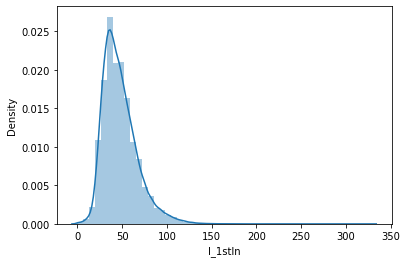

In [ ]:
sns.distplot(ATP_stats.l_1stIn)

In [ ]:
none_percent = match_data.isnull().sum() * 100 / len(match_data)
none_values_df = pd.DataFrame({'Feature name': match_data.columns, 'None values count': match_data.isnull().sum(),
                                 'None values percent': none_percent})
print(none_values_df.reset_index().drop(columns=['index']))

          Feature name  None values count  None values percent
0           Unnamed: 0                  0             0.000000
1           tourney_id                  0             0.000000
2         tourney_name                  0             0.000000
3              surface                  0             0.000000
4            draw_size                  0             0.000000
5        tourney_level                  0             0.000000
6         tourney_date                  0             0.000000
7            match_num                  0             0.000000
8            winner_id                  0             0.000000
9          winner_seed              39832            58.395273
10        winner_entry              59742            87.584114
11         winner_name                  0             0.000000
12         winner_hand                  9             0.013194
13           winner_ht               1465             2.147747
14          winner_ioc                  0             0

In [ ]:
features_to_remove = none_values_df[none_values_df["None values percent"] > 85]
print(features_to_remove)
match_data = match_data.drop(columns = features_to_remove['Feature name'].values)

              Feature name  None values count  None values percent
winner_entry  winner_entry              59742            87.584114


In [ ]:
match_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          68211 non-null  int64  
 1   tourney_id          68211 non-null  object 
 2   tourney_name        68211 non-null  object 
 3   surface             68211 non-null  object 
 4   draw_size           68211 non-null  int64  
 5   tourney_level       68211 non-null  object 
 6   tourney_date        68211 non-null  int64  
 7   match_num           68211 non-null  int64  
 8   winner_id           68211 non-null  int64  
 9   winner_seed         28379 non-null  object 
 10  winner_name         68211 non-null  object 
 11  winner_hand         68202 non-null  object 
 12  winner_ht           66746 non-null  float64
 13  winner_ioc          68211 non-null  object 
 14  winner_age          68208 non-null  float64
 15  loser_id            68211 non-null  int64  
 16  lose

In [ ]:
match_dropped = match_data.drop(columns = ['score','tourney_name','winner_name',
                      'loser_name','minutes', 'l_1stIn', 'l_1stWon', 'l_2ndWon','l_ace', 'l_svpt',
                      'l_SvGms','l_bpFaced','l_df', 'l_bpSaved',  'w_1stIn', 'w_1stWon','w_2ndWon', 'w_SvGms',
                      'w_ace', 'w_svpt','w_bpFaced', 'w_bpSaved','w_df'])
print("remained features ", match_dropped.columns)

remained features  Index(['Unnamed: 0', 'tourney_id', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_hand',
       'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_seed',
       'loser_entry', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age',
       'best_of', 'round', 'winner_rank', 'winner_rank_points', 'loser_rank',
       'loser_rank_points', 'year'],
      dtype='object')


In [ ]:
none_percent = match_dropped.isnull().sum() * 100 / len(match_dropped)
none_values_df = pd.DataFrame({'Feature name': match_dropped.columns, 'None values count': match_dropped.isnull().sum(),
                                 'None values percent': none_percent})
print(none_values_df.reset_index().drop(columns=['index']))

          Feature name  None values count  None values percent
0           Unnamed: 0                  0             0.000000
1           tourney_id                  0             0.000000
2              surface                  0             0.000000
3            draw_size                  0             0.000000
4        tourney_level                  0             0.000000
5         tourney_date                  0             0.000000
6            match_num                  0             0.000000
7            winner_id                  0             0.000000
8          winner_seed              39832            58.395273
9          winner_hand                  9             0.013194
10           winner_ht               1465             2.147747
11          winner_ioc                  0             0.000000
12          winner_age                  3             0.004398
13            loser_id                  0             0.000000
14          loser_seed              52593            77

In [ ]:
features_to_remove = none_values_df[none_values_df["None values percent"] > 85]
print(features_to_remove)
match_dropped = match_dropped.drop(columns=features_to_remove['Feature name'].values)

Empty DataFrame
Columns: [Feature name, None values count, None values percent]
Index: []


In [ ]:
numeric_columns = ['winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht']
match_dropped[numeric_columns] = match_dropped[numeric_columns].astype(float)

In [ ]:
match_dropped = match_dropped.rename(columns={"loser_age": "first_age", "loser_entry": "first_entry", "loser_hand": "first_hand",
                        "loser_ht": "first_ht", "loser_id": "first_id", "loser_ioc": "first_ioc",
                        "loser_rank": "first_rank", "loser_rank_points": "first_rank_points",
                        "loser_seed": "first_seed",
                
                        "winner_age": "second_age", "winner_entry": "second_entry","winner_hand": "second_hand",
                        "winner_ht": "second_ht", "winner_id": "second_id", "winner_ioc": "second_ioc",
                        "winner_rank": "second_rank", "winner_rank_points": "second_rank_points",
                        "winner_seed": "second_seed",
                       },)

In [ ]:
copy_2_df = match_dropped.copy()
copy_2_df[[ 'first_age','first_hand','first_ht','first_id','first_ioc','first_rank','first_rank_points','first_seed',
            'second_age','second_hand','second_ht','second_id','second_ioc','second_rank','second_rank_points','second_seed']]\
=copy_2_df[['second_age','second_hand','second_ht','second_id','second_ioc','second_rank','second_rank_points','second_seed',
             'first_age','first_hand','first_ht','first_id','first_ioc','first_rank','first_rank_points','first_seed']]

In [ ]:
match_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          68211 non-null  int64  
 1   tourney_id          68211 non-null  object 
 2   surface             68211 non-null  object 
 3   draw_size           68211 non-null  int64  
 4   tourney_level       68211 non-null  object 
 5   tourney_date        68211 non-null  int64  
 6   match_num           68211 non-null  int64  
 7   second_id           68211 non-null  int64  
 8   second_seed         28379 non-null  object 
 9   second_hand         68202 non-null  object 
 10  second_ht           66746 non-null  float64
 11  second_ioc          68211 non-null  object 
 12  second_age          68208 non-null  float64
 13  first_id            68211 non-null  int64  
 14  first_seed          15618 non-null  object 
 15  first_entry         13830 non-null  object 
 16  firs

In [ ]:
winner_player2 = np.zeros(match_dropped.shape[0]) # second player wins so label=0
match_dropped['label'] = winner_player2


winner_player1 = np.ones(copy_2_df.shape[0]) # first player wins so label=1
copy_2_df['label'] = winner_player1 

match_dropped = pd.concat([match_dropped,copy_2_df])
#shuffle data
match_dropped = match_dropped.sample(frac=1).reset_index(drop=True)
match_dropped

,Unnamed: 0,tourney_id,surface,draw_size,tourney_level,tourney_date,match_num,second_id,second_seed,second_hand,...,first_ioc,first_age,best_of,round,second_rank,second_rank_points,first_rank,first_rank_points,year,label
0,1730,2001-439,Clay,32,A,20010716,4,103264,NaN,L,...,ARG,24.8,3,R32,124.0,321.0,88.0,486.0,2001,1.0
1,1464,2022-0311,Grass,32,A,20220613,295,200221,NaN,R,...,NED,26.6,3,QF,44.0,1050.0,29.0,1364.0,2022,1.0
2,548,2020-6932,Clay,32,A,20200217,270,106065,NaN,R,...,SRB,29.6,3,R32,111.0,508.0,23.0,1641.0,2020,1.0
3,572,2011-499,Hard,32,A,20110221,1,104534,NaN,R,...,AUS,25.5,3,R32,91.0,568.0,135.0,395.0,2011,0.0
4,1586,2015-311,Grass,32,A,20150615,16,106401,NaN,R,...,SUI,30.2,3,R32,28.0,1245.0,4.0,5790.0,2015,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136417,1265,2020-0352,Hard,64,M,20201102,263,106065,NaN,R,...,SVK,30.2,3,R64,79.0,811.0,105.0,682.0,2020,1.0
136418,2952,2004-96,Hard,64,A,20040816,59,103888,NaN,R,...,RUS,22.1,3,QF,35.0,865.0,45.0,765.0,2004,0.0
136419,774,2010-D015,Clay,4,D,20100306,1,103454,NaN,R,...,ISR,24.9,5,RR,92.0,544.0,66.0,709.0,2010,0.0
136420,1194,2011-468,Clay,28,A,20110425,18,104122,NaN,R,...,FRA,26.3,3,R16,72.0,714.0,22.0,1475.0,2011,1.0


In [ ]:
match_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136422 entries, 0 to 136421
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          136422 non-null  int64  
 1   tourney_id          136422 non-null  object 
 2   surface             136422 non-null  object 
 3   draw_size           136422 non-null  int64  
 4   tourney_level       136422 non-null  object 
 5   tourney_date        136422 non-null  int64  
 6   match_num           136422 non-null  int64  
 7   second_id           136422 non-null  int64  
 8   second_seed         43997 non-null   object 
 9   second_hand         136372 non-null  object 
 10  second_ht           131994 non-null  float64
 11  second_ioc          136422 non-null  object 
 12  second_age          136418 non-null  float64
 13  first_id            136422 non-null  int64  
 14  first_seed          43997 non-null   object 
 15  first_entry         27660 non-null

In [ ]:
hand_encoder = LabelEncoder()
match_dropped['first_hand'] = hand_encoder.fit_transform(match_dropped['first_hand'].astype(str))
match_dropped['second_hand'] = hand_encoder.transform(match_dropped['second_hand'].astype(str))

match_dropped['first_seed'] = hand_encoder.fit_transform(match_dropped['first_seed'].astype(str))
match_dropped['second_seed'] = hand_encoder.fit_transform(match_dropped['second_seed'].astype(str))

match_dropped['first_entry'] = hand_encoder.fit_transform(match_dropped['first_entry'].astype(str))



match_dropped['first_ioc'] = LabelEncoder().fit_transform(match_dropped['first_ioc'].astype(str))
match_dropped['second_ioc'] = LabelEncoder().fit_transform(match_dropped['second_ioc'].astype(str))

match_dropped['surface'] = LabelBinarizer().fit_transform(match_dropped['surface'].astype(str))
match_dropped['tourney_level'] = LabelEncoder().fit_transform(match_dropped['tourney_level'].astype(str))
match_dropped['tourney_id'] = LabelEncoder().fit_transform(match_dropped['tourney_id'].astype(str))
match_dropped['round'] = LabelEncoder().fit_transform(match_dropped['round'].astype(str))

match_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136422 entries, 0 to 136421
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          136422 non-null  int64  
 1   tourney_id          136422 non-null  int64  
 2   surface             136422 non-null  int64  
 3   draw_size           136422 non-null  int64  
 4   tourney_level       136422 non-null  int64  
 5   tourney_date        136422 non-null  int64  
 6   match_num           136422 non-null  int64  
 7   second_id           136422 non-null  int64  
 8   second_seed         136422 non-null  int64  
 9   second_hand         136422 non-null  int64  
 10  second_ht           131994 non-null  float64
 11  second_ioc          136422 non-null  int64  
 12  second_age          136418 non-null  float64
 13  first_id            136422 non-null  int64  
 14  first_seed          136422 non-null  int64  
 15  first_entry         136422 non-nul

In [ ]:
df_imputed = pd.DataFrame(SimpleImputer().fit_transform(match_dropped))
df_imputed.columns = match_dropped.columns
df_imputed.index = match_dropped.index
match_dropped = df_imputed.copy()

In [ ]:
print('Final shape of data after cleaning and preprocessing: ', match_dropped.shape)


Final shape of data after cleaning and preprocessing:  (136422, 28)


In [ ]:
y = match_dropped['label']
match_dropped_X = match_dropped.drop(columns = 'label')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(match_dropped_X, y, test_size=0.2)


In [ ]:
RF_classifier = RandomForestClassifier(n_estimators=100)
#fit the data
RF_classifier.fit(X_train, y_train)
#predict 
RF_predictions = RF_classifier.predict(X_test)

In [ ]:
print('Confusion matrix')
print(confusion_matrix(y_test,RF_predictions))
print('Classification report')
print(classification_report(y_test,RF_predictions))
print('Accuracy= ', accuracy_score(y_test, RF_predictions))

Confusion matrix
[[9593 3983]
 [4220 9489]]
Classification report
              precision    recall  f1-score   support

         0.0       0.69      0.71      0.70     13576
         1.0       0.70      0.69      0.70     13709

    accuracy                           0.70     27285
   macro avg       0.70      0.70      0.70     27285
weighted avg       0.70      0.70      0.70     27285

Accuracy=  0.6993586219534543


In [ ]:
#Call the classifier
XGB_classifier = XGBClassifier()
#fit the data
XGB_classifier.fit(X_train, y_train)
#predict 
XGB_predictions = XGB_classifier.predict(X_test)

In [ ]:
print('Confusion matrix')
print(confusion_matrix(y_test,XGB_predictions))
print('Classification report')
print(classification_report(y_test,XGB_predictions))
print('Accuracy= ', accuracy_score(y_test, XGB_predictions))

Confusion matrix
[[9245 4331]
 [4492 9217]]
Classification report
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68     13576
         1.0       0.68      0.67      0.68     13709

    accuracy                           0.68     27285
   macro avg       0.68      0.68      0.68     27285
weighted avg       0.68      0.68      0.68     27285

Accuracy=  0.6766355140186916


In [ ]:
match_dropped.columns

Index(['Unnamed: 0', 'tourney_id', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'second_id', 'second_seed', 'second_hand',
       'second_ht', 'second_ioc', 'second_age', 'first_id', 'first_seed',
       'first_entry', 'first_hand', 'first_ht', 'first_ioc', 'first_age',
       'best_of', 'round', 'second_rank', 'second_rank_points', 'first_rank',
       'first_rank_points', 'year', 'label'],
      dtype='object')

In [ ]:
RF_classifier.feature_importances_

array([0.05234231, 0.04054926, 0.00177845, 0.01539864, 0.00767157,
       0.03915741, 0.04158627, 0.04317325, 0.0269187 , 0.0064419 ,
       0.02882616, 0.03425898, 0.04922087, 0.04319584, 0.02693221,
       0.06360751, 0.0062517 , 0.02884763, 0.03420737, 0.04930499,
       0.00426756, 0.01890544, 0.08038755, 0.07834304, 0.08100392,
       0.07821918, 0.01920231])

In [ ]:
import shap

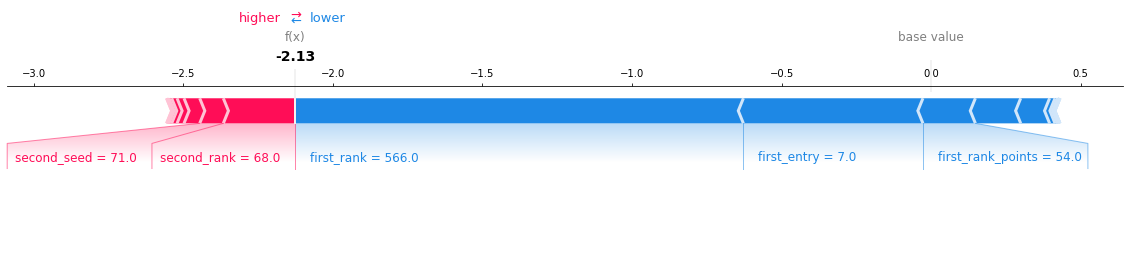

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(XGB_classifier)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)

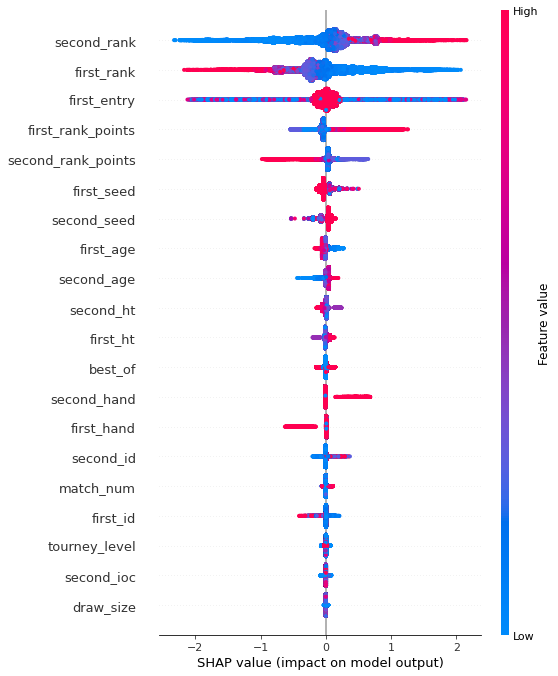

In [ ]:
shap.summary_plot(shap_values, X_train)


In [ ]:
from sklearn.decomposition import PCA
#match_dropped.info()
pca = PCA(n_components = 27)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_

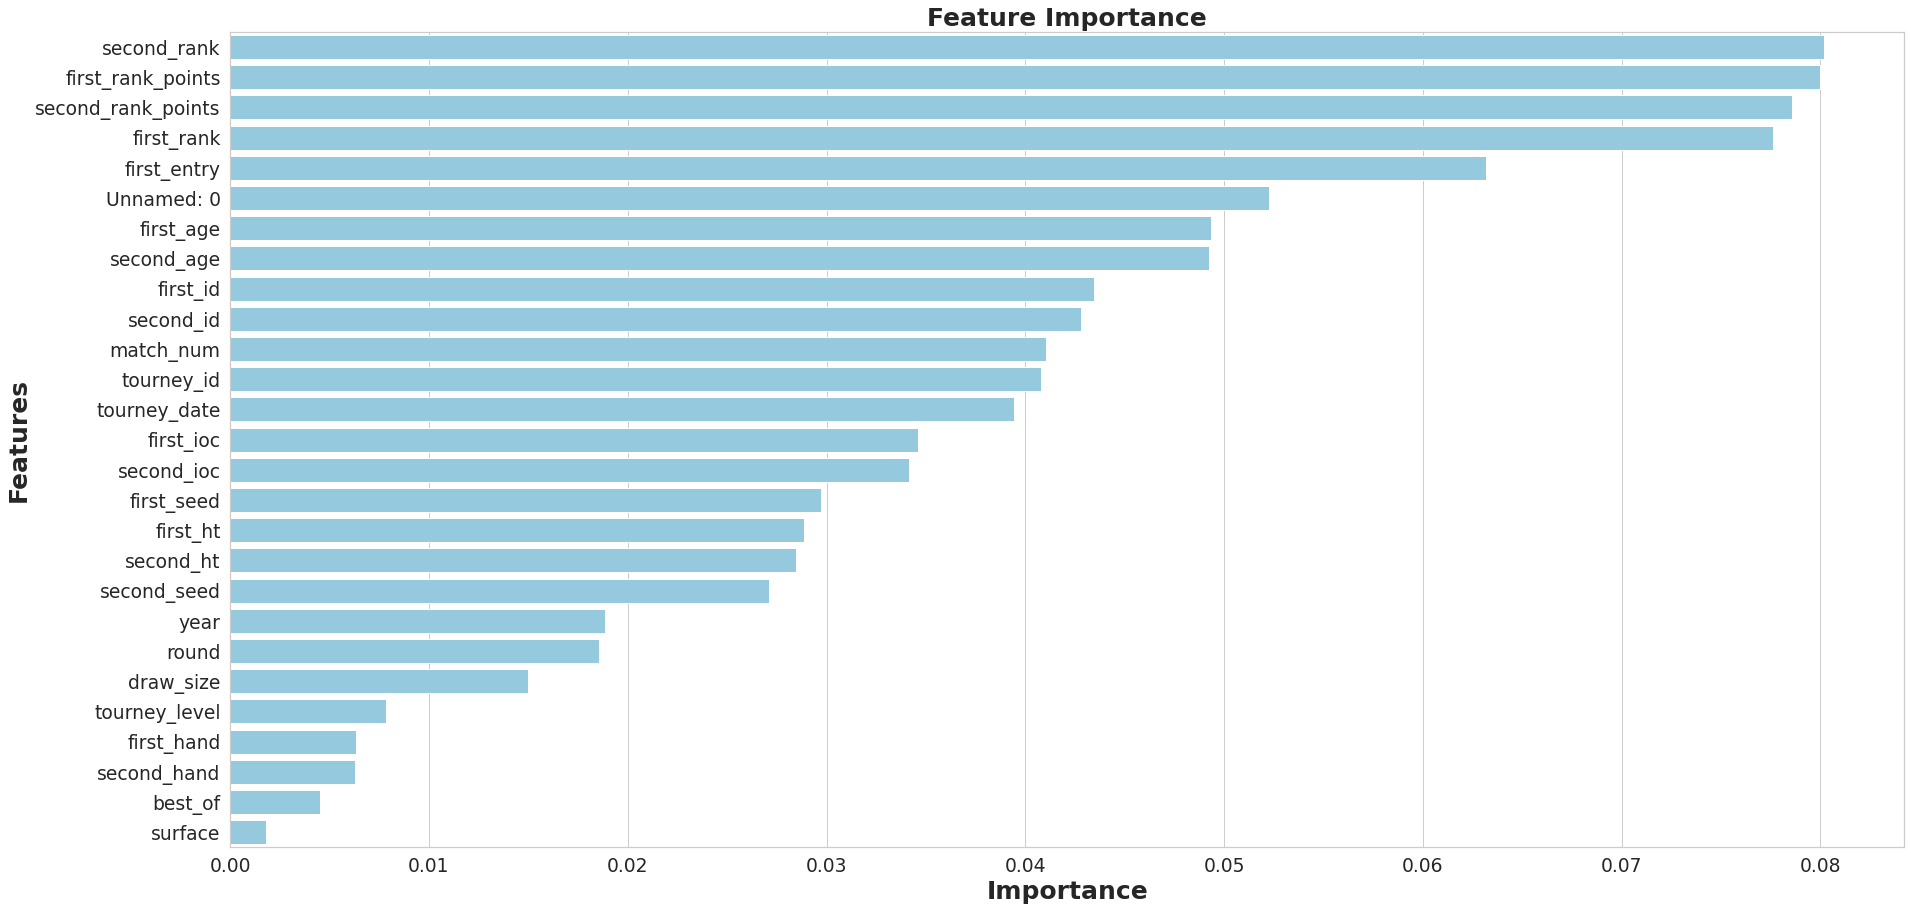

None

,Features,Gini-Importance
0,second_rank,0.080205
1,first_rank_points,0.079965
2,second_rank_points,0.078587
3,first_rank,0.077610
4,first_entry,0.063181
5,Unnamed: 0,0.052257
6,first_age,0.049333
7,second_age,0.049239
8,first_id,0.043472
9,second_id,0.042819


In [ ]:
feats = {}
for feature, importance in zip(match_dropped.columns, RF_classifier.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [ ]:
import tensorflow as tf

In [ ]:
feature_cols = tf.contrib.learn.infer_real_valued_columns_from